# Overlapping Mixtures of Gaussian Processses

*Valentine Svensson 2015 <br> (with small edits by James Hensman November 2015) 
converted to GPflow by Daniel Marthaler September 2016*

This illustrates use of the OMGP model described in

**Overlapping Mixtures of Gaussian Processes for the data association problem**  
_Miguel Lázaro-Gredilla, Steven Van Vaerenbergh, Neil D. Lawrence_  
Pattern Recognition 2012

The GPclust implementation makes use of the collapsed variational mixture model for GP assignment.

In [1]:
%matplotlib inline
import numpy as np
import GPflow
from GPclust import OMGP
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,6)
from matplotlib import pyplot as plt

## Diverging trend seperation

One application of the OMGP model could be to find diverging trends among populations over time. Imagine for example two species evolving from a common ancestor over time.

We load some pre-generated data which diverge over time.

In [2]:
XY = np.loadtxt('../data/split_data_test.csv', delimiter=',', skiprows=1, usecols=[1, 2])
X = XY[:, 0, None]
Y = XY[:, 1, None]

In [3]:
#plt.scatter(X, Y);

We define a model assuming `num_clusters` = 2 trends. By default the model will be populated by `num_clusters` RBF kernels. The OMGP implementation is compatible with most kernels in GPflow, so that you for example can encode periodicity in the model.

In [4]:
m = OMGP(X, Y, num_clusters=2, noise_variance=0.01, prior_Z='DP')
m.log_likelihood()

AttributeError: 'module' object has no attribute 'Logexp'

A simple plot function is included which illustrates the asignment probability for each data point, it also shows the posterior mean and confidence intervals for each Gaussian Process.

In [5]:
from plotter import OMGPplot
#OMGPplot(m,X,Y)

There is also a function for plotting the assignment probability for a given GP directly. Since we haven't optimized the mixture parameters yet the assignment probability is just a random draw from the prior.

In [6]:
from plotter import OMGPplot_probs
#OMGPplot_probs(m, X, gp_num=0)

We can first performa a quick optimization to find the rough trends.

In [7]:
m.optimize(step_length=0.01, maxiter=20)

iteration 1 bound=-367.44376512 grad=403.317771334, beta=0
iteration 2 bound=-359.749422002 grad=361.713946799, beta=1.01632336897
iteration 3 bound=-348.983191314 grad=307.410208481, beta=1.01644575006
iteration 4 bound=-336.451133799 grad=249.721291783, beta=0.985868930608
iteration 5 bound=-324.314532321 grad=191.924610322, beta=0.929663031657
iteration 6 bound=-314.185501815 grad=140.001627587, beta=0.870176193905
iteration 7 bound=-306.563870286 grad=98.4761052283, beta=0.821532125779
iteration 8 bound=-301.334281729 grad=68.4064852479, beta=0.777809343009
iteration 9 bound=-298.018460038 grad=48.8100748898, beta=0.726653535999
iteration 10 bound=-295.94047249 grad=36.7376058589, beta=0.697471213299
iteration 11 bound=-294.492868142 grad=28.6590535227, beta=0.749324830805
iteration 12 bound=-293.388699781 grad=22.2845732407, beta=0.815965316
iteration 13 bound=-292.527592988 grad=16.9761110563, beta=0.848217660312
iteration 14 bound=-291.8686213 grad=12.7450622887, beta=0.85244759

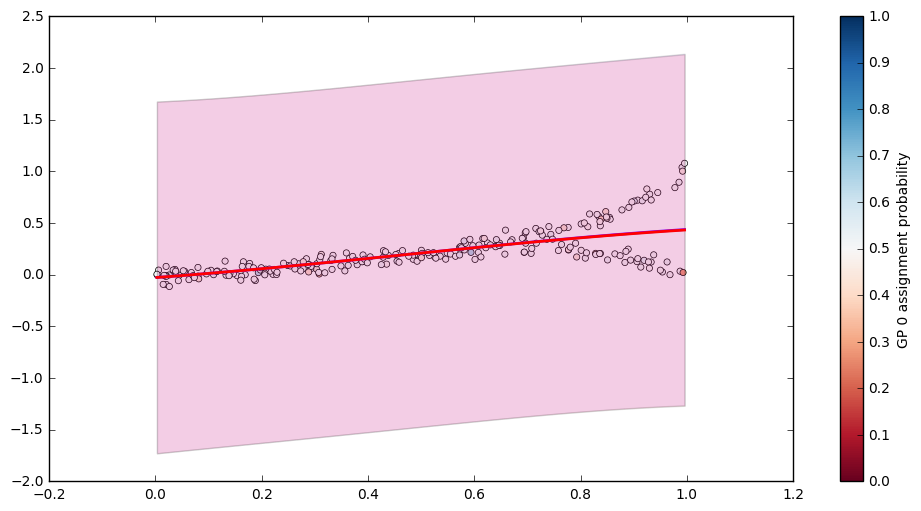

In [8]:
OMGPplot(m,X,Y)

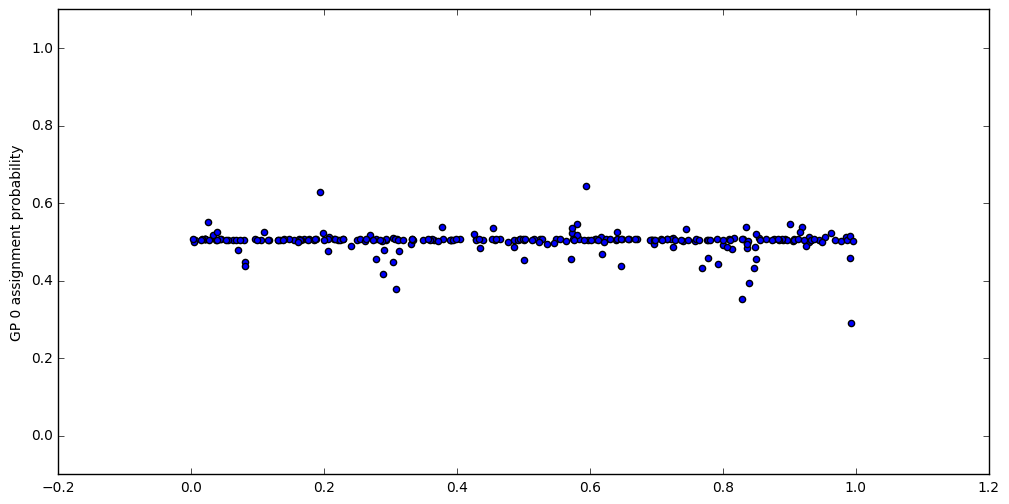

In [9]:
OMGPplot_probs(m,X)

The model identifies the branches of the time series, and in particular the non-branched region have ambigous GP assignment. In this region the two trends share information for prediction.

Like any GPy model the hyper parameters can be inspected.

In [10]:
m

Name,values,prior,constraint
model.noise_variance,[ 0.69815968],None,+ve
model.kern.item0.lengthscales,[ 1.],None,+ve
model.kern.item0.variance,[ 1.],None,+ve
model.kern.item1.lengthscales,[ 1.],None,+ve
model.kern.item1.variance,[ 1.],None,+ve


We continue by letting the model optimize some more, and also allow it to optimize the hyper parameters. The hyper parameter optimization works best if the mixture parameters have converged or are close to converging.

In [11]:
m.optimize(step_length=0.01, maxiter=200)

iteration 1 bound=-290.39010614 grad=3.37157861816, beta=0
iteration 2 bound=-290.326448415 grad=3.23776949615, beta=0.981630542526
iteration 3 bound=-290.239022855 grad=2.98288282127, beta=0.962924676673
iteration 4 bound=-290.13665851 grad=2.63303806238, beta=0.943645759394
iteration 5 bound=-290.029123156 grad=2.22368209455, beta=0.923634724784
iteration 6 bound=-289.925574286 grad=1.79390673605, beta=0.90287220329
iteration 7 bound=-289.833213724 grad=1.38026277149, beta=0.881475982638
iteration 8 bound=-289.756465914 grad=1.01143661382, beta=0.859666641358
iteration 9 bound=-289.696844056 grad=0.705021868753, beta=0.837708913304
iteration 10 bound=-289.653438719 grad=0.467011824324, beta=0.81584798291
iteration 11 bound=-289.623774078 grad=0.293751895851, beta=0.794261850639
iteration 12 bound=-289.60471726 grad=0.175348843861, beta=0.773042588584
iteration 13 bound=-289.593199832 grad=0.0992926399007, beta=0.752206269433
iteration 14 bound=-289.58664779 grad=0.0533324890039, beta

In [12]:
m

Name,values,prior,constraint
model.noise_variance,[ 1.00003906e-06],None,+ve
model.kern.item0.lengthscales,[ 0.02066311],None,+ve
model.kern.item0.variance,[ 20.46915261],None,+ve
model.kern.item1.lengthscales,[ 0.01895688],None,+ve
model.kern.item1.variance,[ 17.9431256],None,+ve


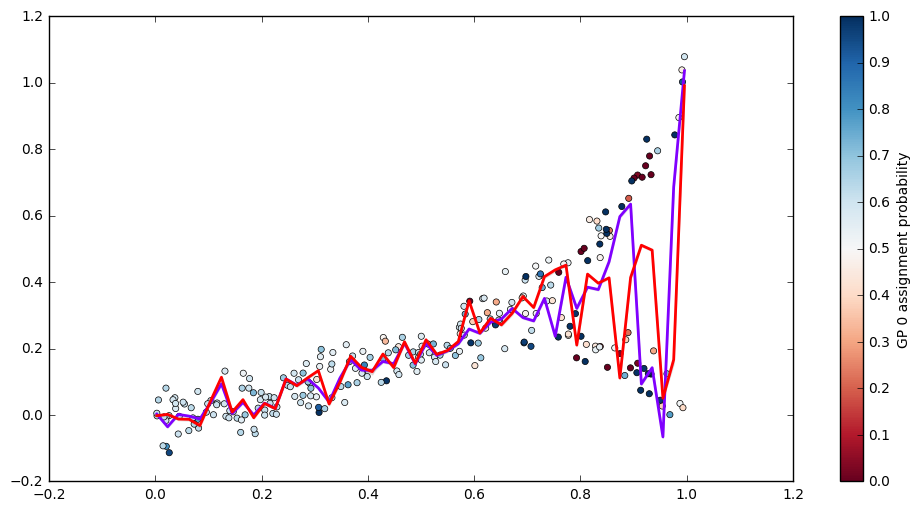

In [13]:
OMGPplot(m,X,Y)

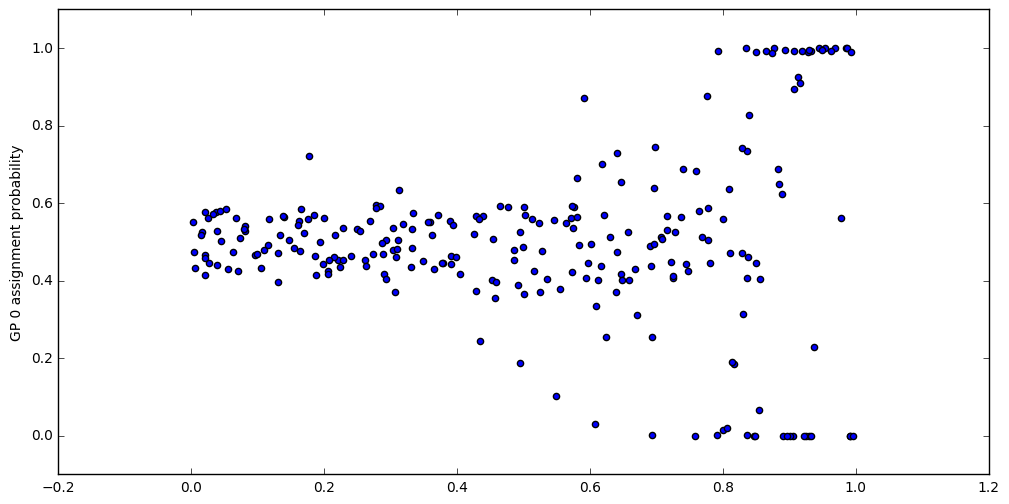

In [14]:
OMGPplot_probs(m,X)

## Separating signal from noise

An interesting application of the OMGP model pointed out in the original publication is the use for robust GP regression.

Let's illustrate this by creating sinusoidal test data with background noise.

In [17]:
x1 = np.random.uniform(0, 10, (100, 1))
x2 = np.random.uniform(0, 10, (100, 1))

y1 = 4 * np.random.randn(*x1.shape)
y2 = 3 * np.sin(x2) + 0.5 * np.random.randn(*x2.shape)
x = np.vstack((x1, x2))
y = np.vstack((y1, y2))

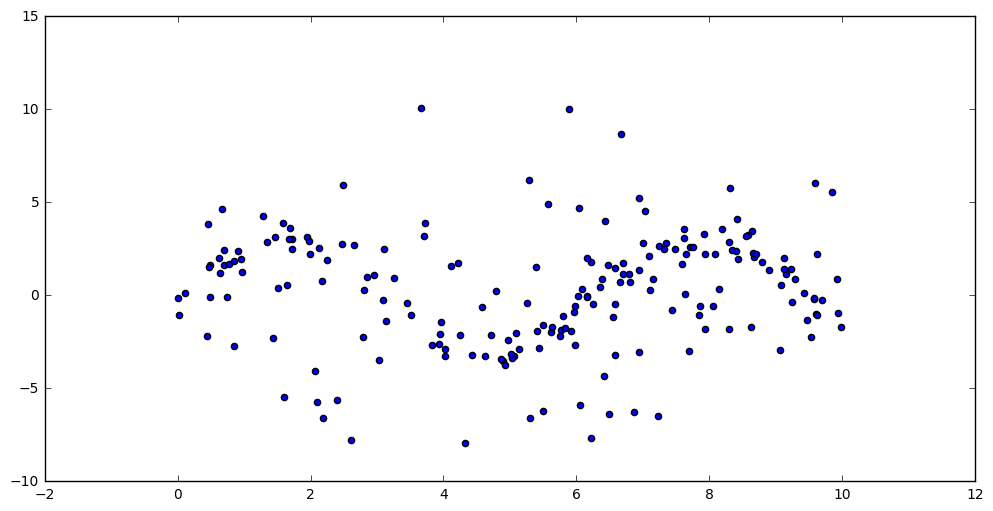

In [18]:
plt.scatter(x, y);

First we make a model with only one mixture component / kernel. This is equivalent to normal GP regression.

In [19]:
kernels = [GPflow.kernels.RBF(1,lengthscales=2.0)]
m = OMGP(x, y, num_clusters=1, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 100

In [22]:
m.optimize(verbose=False)

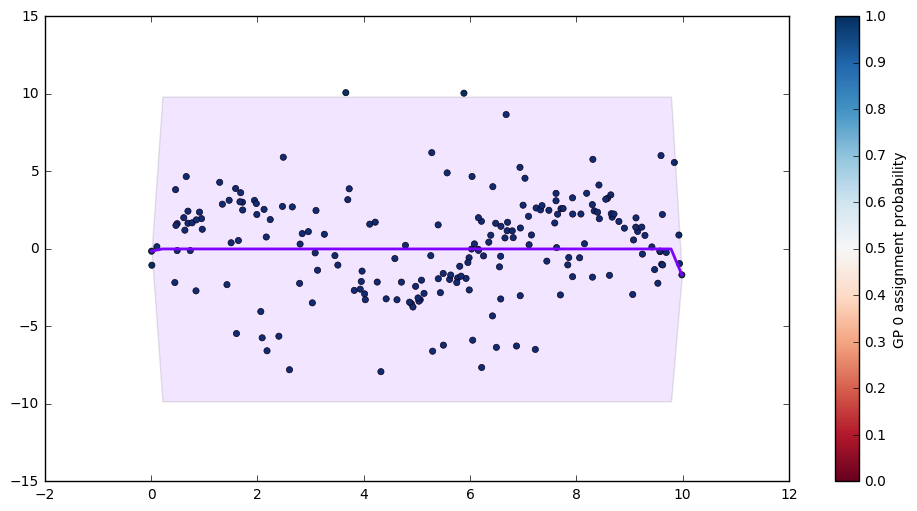

In [23]:
OMGPplot(m,x,y)

Now we in stead view this is a mixture problem, and consider two _different_ kinds of kernels for the different GP components. One encoding white noise, and another which can encode a trend over time (an RBF kernel in this case).

In [24]:
kernels = [GPflow.kernels.White(1), GPflow.kernels.RBF(1, lengthscales=2.0)]
m = OMGP(x, y, num_clusters=2, prior_Z='DP', kernels=kernels, noise_variance=3.)
m.hyperparam_interval = 250

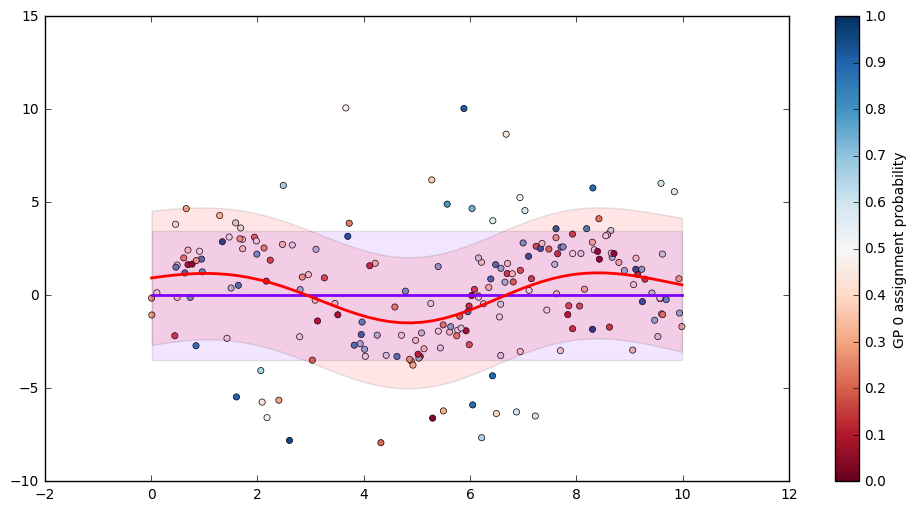

In [25]:
OMGPplot(m,x,y)

In [26]:
m.optimize(step_length=0.01, verbose=False)

In [27]:
m

Name,values,prior,constraint
model.kern.item0.variance,[ 19.74407605],None,+ve
model.kern.item1.variance,[ 171.53066409],None,+ve
model.kern.item1.lengthscales,[ 1.38624301],None,+ve
model.noise_variance,[ 0.22278826],None,+ve


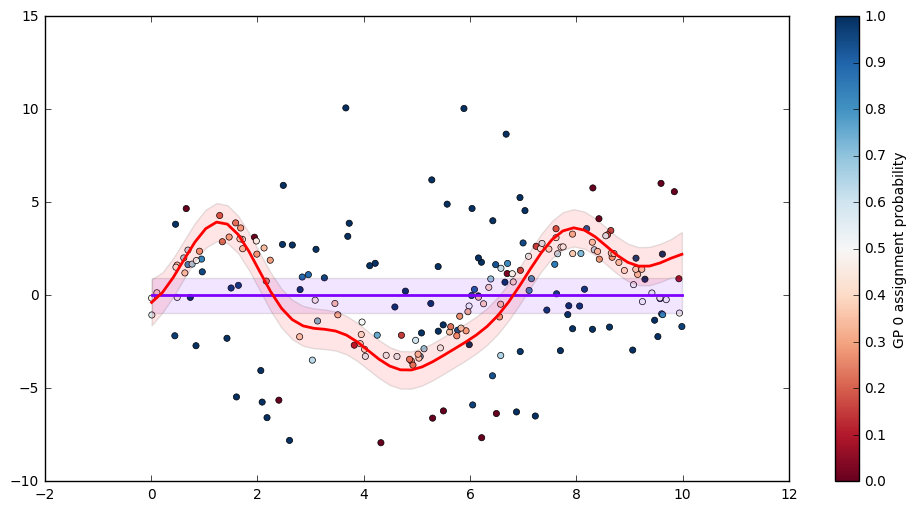

In [28]:
OMGPplot(m,x,y)

The trend over time is much more noticable, and the confidence intervals are smaller.

Noisy points will have high assignment probability to the 'noise GP', while the assignment of the sinusoidal points is ambiguous. We can use this to seperate the points which are more likely to be noise from the remaining points.

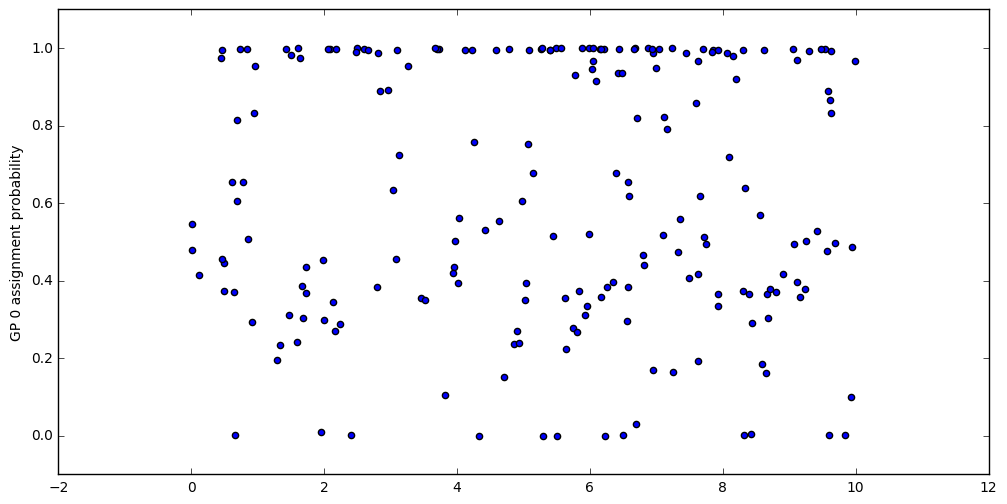

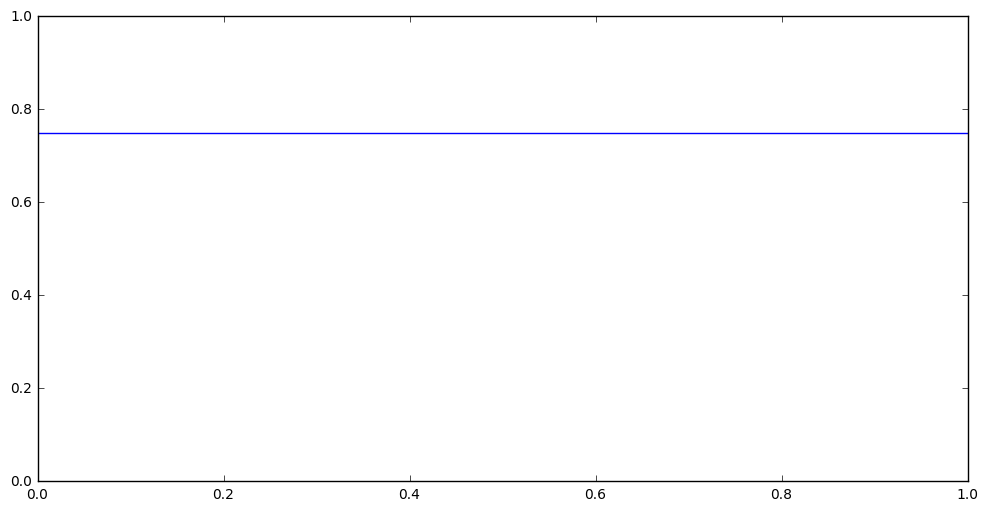

In [29]:
OMGPplot_probs(m,x)
plt.axhline(0.75);

In [30]:
thr = 0.75
phi = m.get_phi()
idx = np.where(phi[:,0] < thr)[0]
nidx = np.where(phi[:,0] >= thr)[0]

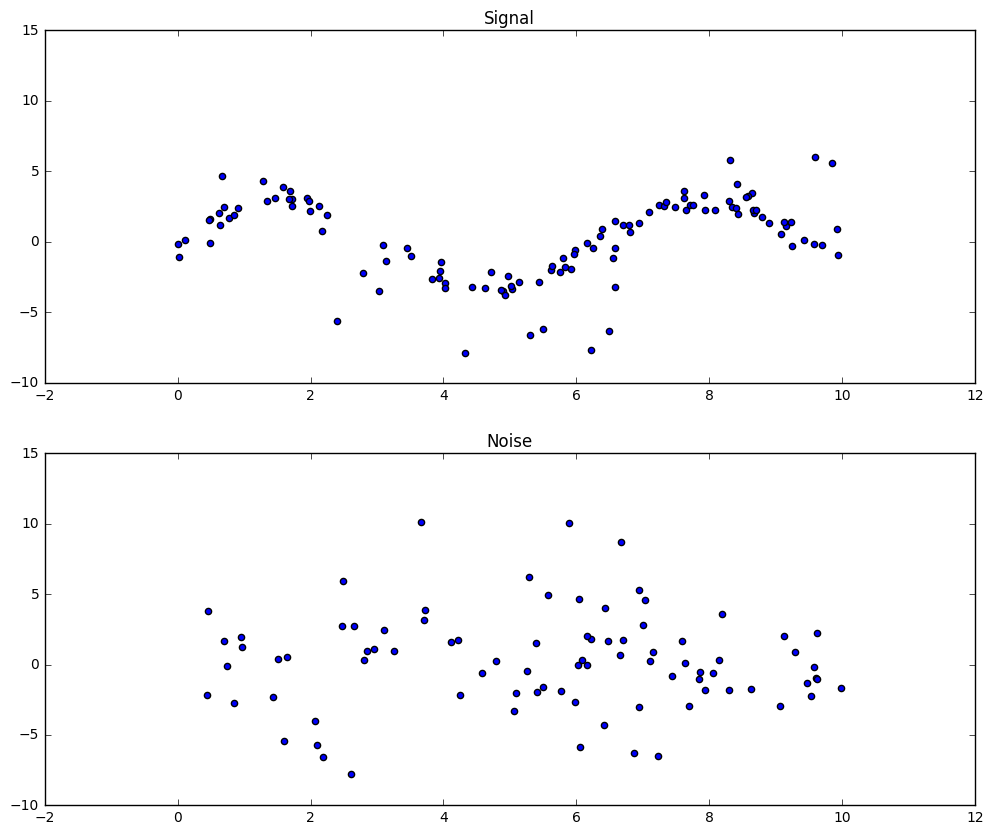

In [31]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.scatter(x[idx], y[idx]);
plt.title('Signal')

plt.subplot(212, sharey=plt.gca())
plt.scatter(x[nidx], y[nidx]);
plt.title('Noise');